In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')
%matplotlib inline

from matplotlib import rcParams
rcParams['axes.titlepad']=20

# Read the StackOverflow survey results and the survey schema from csv files into dataframes

df = pd.read_csv('./survey_results_public.csv')
schema = pd.read_csv('./survey_results_schema.csv',header=0,index_col='Column')

We'll be primarily looking at `Salary` and `JobSatisfaction`, so we'll drop rows that don't have values for those fields.

In [2]:
df = df.dropna(axis=0,subset=['Salary','JobSatisfaction'])
df.shape

(12852, 154)

We'll also be working a lot with the two education columns, so let's check to see if there are any `NA` responses there:

In [3]:
print(df['FormalEducation'].isna().sum())
print(df['HighestEducationParents'].isna().sum())

0
1183


I don't want to drop the NAs from the highest education parents column, because there was an option to not provide a response. I'll lump any NAs in with those later.

The following function allows us to get the list of responses that were provided in a column of the survey. It's then applied to the `FormalEducation` and `HighestEducationParents` columns to get the list of responses that were provided there.

In [4]:
def get_possible_responses(df,column):
    '''
    A function to get the possible responses from a multiple-response categorical column
    Note: this function assumes that the multiple responses are divided by a semicolon...
    if this isn't true, the function will need to be modified.
    
    INPUT:
        df - dataframe with a column that has a multi-response categorical column
        column - the name of the column for which you want to find possible responses
    OUTPUT:
        possible_responses - a list of possible responses
    '''
    possible_responses = []
    
    for response in df[column].dropna().unique():
        new_response = response.split('; ')        
        possible_responses = possible_responses + new_response
    
    possible_responses = pd.Series(possible_responses)
    possible_responses = possible_responses.unique().tolist()
    return possible_responses

get_possible_responses(df,'FormalEducation')

["Bachelor's degree",
 'Professional degree',
 "Master's degree",
 "Some college/university study without earning a bachelor's degree",
 'Doctoral degree',
 'Secondary school',
 'I never completed any formal education',
 'Primary/elementary school',
 'I prefer not to answer']

In [5]:
get_possible_responses(df,'HighestEducationParents')

['A professional degree',
 'High school',
 "A master's degree",
 "A bachelor's degree",
 'A doctoral degree',
 'Primary/elementary school',
 "Some college/university study, no bachelor's degree",
 "I don't know/not sure",
 'No education',
 'I prefer not to answer']

In [6]:
df['FormalEducation'].value_counts()

Bachelor's degree                                                    6395
Master's degree                                                      3062
Some college/university study without earning a bachelor's degree    2042
Secondary school                                                      759
Doctoral degree                                                       293
Professional degree                                                   143
I never completed any formal education                                 60
Primary/elementary school                                              55
I prefer not to answer                                                 43
Name: FormalEducation, dtype: int64

Here we take the possible responses and group them according to different levels of education:
* Non-responses are grouped together as "No response". 
* Any education level at high school or less is grouped together as "No higher education". 
* Any amount of college education that didn't result in a full Bachelor's degree is grouped as "Some higher ed".
* Bachelor's degrees, the largest group of responses, get their own category.
* Master's degrees and doctorates are grouped together.

In [7]:
dont_know_ed = ["I don't know/not sure",'I prefer not to answer']

no_higher_ed = ['No education','Primary/elementary school', 'High school','I never completed any formal education',
                'Secondary school']

some_higher_ed = ["Some college/university study, no bachelor's degree","A professional degree", 
                  "Some college/university study without earning a bachelor's degree", 'Professional degree']

bachelors_ed = ["Bachelor's degree","A bachelor's degree"]

graduate_ed = ["A master's degree",'A doctoral degree',"Master's degree",'Doctoral degree']

ordered_ed = ["No response", "No higher education","Some college","Bachelor's degree","Graduate degree"]

def formal_education_levels(formal_education):
    if (formal_education in dont_know_ed  or pd.isnull(formal_education)):
        return ordered_ed[0]
    elif formal_education in no_higher_ed:
        return ordered_ed[1]
    elif formal_education in some_higher_ed:
        return ordered_ed[2]
    elif formal_education in bachelors_ed:
        return ordered_ed[3]
    elif formal_education in graduate_ed:
        return ordered_ed[4]
    else: # The lists above should contain all the options for responding, but this allows us to see if we missed something
        return "ERROR" 
    
df['FormalEducation']=df['FormalEducation'].apply(formal_education_levels)
df['HighestEducationParents']=df['HighestEducationParents'].apply(formal_education_levels)

Let's just check to make sure things add up and we didn't get any errors.

In [8]:
print(df['FormalEducation'].value_counts(),'\n')
print(df['HighestEducationParents'].value_counts())

Bachelor's degree      6395
Graduate degree        3355
Some college           2185
No higher education     874
No response              43
Name: FormalEducation, dtype: int64 

Bachelor's degree      3541
Graduate degree        3213
No higher education    2520
Some college           2163
No response            1415
Name: HighestEducationParents, dtype: int64


The following chunk applies an ordered categorical type to the `FormalEducation` and `HighestEducationParents` columns, to make plots ordered by increasing education level easier later on. We couldn't do this when applying the `formal_education_levels` function above, because categorical variables break when they're not in a DataFrame or Series.

In [9]:
from pandas.api.types import CategoricalDtype
ed_ord_cat = CategoricalDtype(categories=ordered_ed,ordered=True)

df['FormalEducation']=df['FormalEducation'].astype(ed_ord_cat)
df['HighestEducationParents']=df['HighestEducationParents'].astype(ed_ord_cat)

Now, when we do a bar plot, values are presented in the correct order.

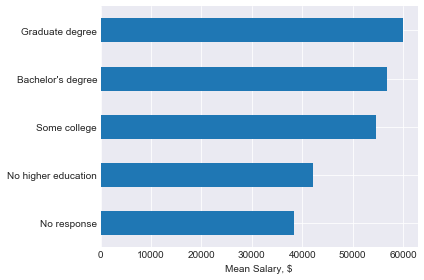

In [10]:
df.groupby(['FormalEducation'])['Salary'].mean().plot.barh()
plt.xlabel("Mean Salary, $");
plt.ylabel("");
plt.tight_layout();
plt.savefig('Mean Salary by FormalEducation.png',dpi=300)

Below we'll look at the responses in the `MajorUndergrad` column, and then make a plot of mean salary for each of the responses.

In [11]:
df['MajorUndergrad'].value_counts()

Computer science or software engineering                        6468
Computer engineering or electrical/electronics engineering      1093
Computer programming or Web development                          990
A natural science                                                488
Information technology, networking, or system administration     476
Mathematics or statistics                                        444
A non-computer-focused engineering discipline                    424
A humanities discipline                                          278
Something else                                                   274
A business discipline                                            220
Fine arts or performing arts                                     194
Management information systems                                   180
A social science                                                 164
I never declared a major                                         162
Psychology                        

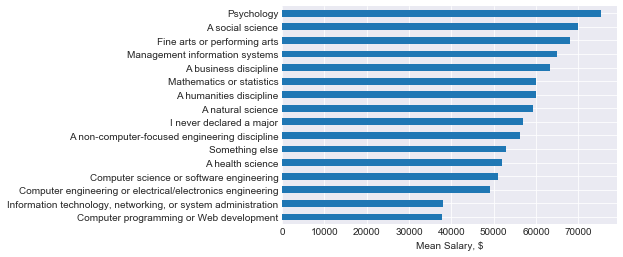

In [12]:
df.groupby(['MajorUndergrad'])['Salary'].median().sort_values().plot.barh();
plt.xlabel("Mean Salary, $");
plt.ylabel("");
#plt.tight_layout();
plt.savefig('Mean Salary by MajorUndergrad.png',dpi=300,bbox_inches='tight')

The next code chunk looks at each column, and then decides whether the question associated with that column asked how much you agree or disagree with a statement. If so, it applies an ordered categorical dtype to that column so they'll look nice for our plots. It also prints the results so we can look at them later.

In [13]:
agree_responses_ord = ['Strongly disagree','Disagree','Somewhat agree','Agree','Strongly agree']
agree_ord_cat = CategoricalDtype(categories=agree_responses_ord,ordered=True)

for column in df.columns:
    if df[column].dtype=='object':
        result = all(elem in get_possible_responses(df,column) for elem in agree_responses_ord)
        if result:
            df[column]=df[column].astype(agree_ord_cat)
            print(column)

ProblemSolving
BuildingThings
LearningNewTech
BoringDetails
JobSecurity
DiversityImportant
AnnoyingUI
FriendsDevelopers
RightWrongWay
UnderstandComputers
SeriousWork
InvestTimeTools
WorkPayCare
KinshipDevelopers
ChallengeMyself
CompetePeers
ChangeWorld
ShipIt
OtherPeoplesCode
ProjectManagement
EnjoyDebugging
InTheZone
DifficultCommunication
CollaborateRemote
StackOverflowAdsRelevant
StackOverflowAdsDistracting
StackOverflowModeration
StackOverflowCommunity
StackOverflowHelpful
StackOverflowBetter
StackOverflowWhatDo
StackOverflowMakeMoney
SurveyLong
QuestionsInteresting
QuestionsConfusing
InterestedAnswers


This chunk then plots mean salary grouped by `HighestEducationParents`.

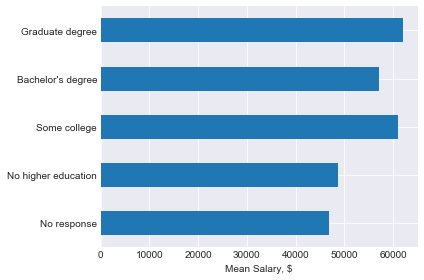

In [14]:
df.groupby(['HighestEducationParents'])['Salary'].mean().plot.barh()
plt.xlabel("Mean Salary, $");
plt.ylabel("");
plt.tight_layout();
plt.savefig('Mean Salary by HighestEducationParents.png',dpi=300)

The following code chunk contains a list of all of the countries in the OECD, then a function to `apply` to the `Country` column, creating a new `oecd` column that states whether the country is in the OECD or not. The function is then applied.

In [15]:
oecd_countries = ['Australia','Austria','Belgium','Canada','Chile','Czech Republic'
                  'Denmark','Estonia','Finland','France','Germany','Greece',
                  'Hungary','Iceland','Israel','Italy','Japan','Korea','Latvia',
                  'Lithuania','Luxembourg','Mexico','Netherlands','New Zealand',
                  'Norway','Poland','Portugal','Slovak Republic','Slovenia','Spain',
                  'Sweden','Switzerland','Turkey','United Kingdom','United States']

# This function will be used to add a column to the dataset that identifies whether a given 
# respondent is from an OECD country or not

def oecd_country(country_str):
    if country_str in oecd_countries:
        return 'oecd'
    else:
        return 'non-oecd'
    
# Here we apply the function to the dataframe
    
df['oecd']=df['Country'].apply(oecd_country)

I had a bunch of instances where I wanted to do about the same thing, so I made a function, `group_plot`, for it. 

This function allows you to make group-based plots relatively easily. For input, it takes a dataframe, a list of columns from that dataframe that you may want to group by (should work with either one or two columns, may not work with more), and optionally a response variable that you're looking to plot (the default is `Salary`). If you want to normalize to the mean of one of the groups (for example, when looking at OECD and non-OECD countries, it makes sense to have them both normalized to their own mean because otherwise they're not comparable), you have the option to do that. You can also pick which group is the major group on the y-axis of the plot, and whether to plot or not.

In [16]:
def group_plot(data,groups,response_var='Salary',mean_group=0,major_plot_group=0,plot=True):
    '''
    
    A function that groups, normalizes and plots data from a Pandas dataframe, by default in a horizontal bar
    plot.
    
    INPUT:
        data - A dataframe that contains columns listed in groups, response_var, and mean_group (if included).
        groups - A list containing column names for variables that you want to group by. Columns must be in data.
        response_var - The response variable you'd like to plot as the x-axis of the horizontal bar plot. Column
                       must be in data.
        mean_group - Column name for the group you want to normalize the response variable to. If included, this
                     should be in groups.
        major_plot_group - Use a 0 for the first group in groups to be the major y-axis plot group, use a 1 for
                           the second group to be the major y-axis plot group.
        plot - Determines whether plots are generated and saved to file.
    OUTPUT:
        plot_df - A dataframe that contains the grouped, normalized data. If you don't want to use the built-in
                  plots from the function or if something gets messed up along the way, this is useful.
    '''
    
    dfa = data.dropna(subset=groups)
    plot_df = pd.DataFrame()
    groupnames = ' and '.join(groups)
        
    if mean_group==0:
        for name,group in dfa.groupby(groups):
            normalized_dev = (group[response_var].mean()-dfa[response_var].mean())/dfa[response_var].std()
            plot_df.loc[name]=normalized_dev
        title = 'Normalized Deviation from Mean '+response_var
    else:
        grouped = dfa.groupby(mean_group)[response_var]
        group_mean = grouped.mean()
        group_std = grouped.std()

        for name,group in dfa.groupby(groups):
            normalized_dev = (group[response_var].mean()-group_mean[name[0]])/group_std[name[0]]
            plot_df.loc[name]=normalized_dev
        meangroupname = ''.join(mean_group)
        title = 'Normalized Deviation from '+meangroupname+' Group Mean '+response_var
    
    # Everything below here just has to do with plotting
    
    lgdtitle = groups[1]
    ytitle = groups[0]
    if major_plot_group==1:
        plot_df = plot_df.T
        lgdtitle = groups[0]
        ytitle = groups[1]
    
    if plot:
        plot_df.reindex()
        plot_df.plot.barh()
        plt.ylabel(ytitle)
        lgd = plt.legend(loc='center left',bbox_to_anchor = (1.04,0.5),title=lgdtitle)
        #plt.title(title)
        plt.savefig(title+' Grouped by '+groupnames+'.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=300)
    
    return plot_df

The next chunks then apply this `group_plot` function to look at the data grouped by `oecd` and `HighestEducationParents`/`FormalEducation` with the mean salary for each subgroup normalized to the `oecd` or `non-oecd` mean salary, depending on the subgroup.

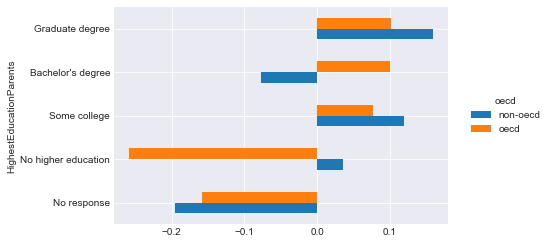

In [17]:
group_plot(df,['oecd','HighestEducationParents'],mean_group=['oecd'],major_plot_group=1);

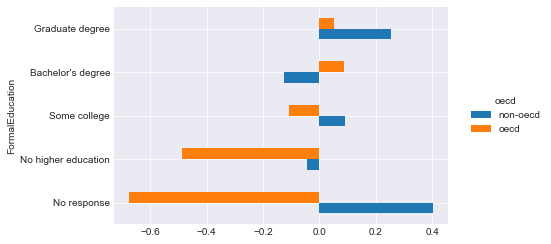

In [18]:
group_plot(df,['oecd','FormalEducation'],mean_group=['oecd'],major_plot_group=1);

Here, we're looking at just the `oecd`data, and we're grouping it by `FormalEducation` and `HighestEducationParents`.

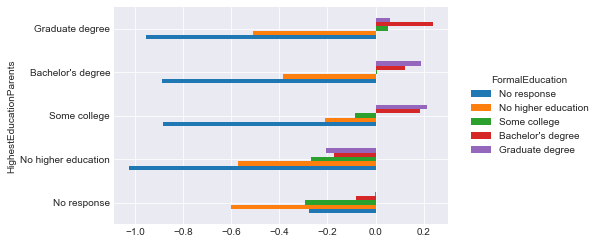

In [35]:
#Select only rows from OECD countries
oecd_data = df[df['oecd']=='oecd']
group_plot(oecd_data,['FormalEducation','HighestEducationParents'],major_plot_group=1);
lgd = plt.legend(loc='center left',bbox_to_anchor = (1.04,0.5),title='FormalEducation')
plt.savefig('OECD - Normalized Deviation from Mean Salary Grouped by HEP and FE.png',bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=300)

Doing the same for the `non-oecd` data somehow messed up the order of the columns, so I plotted the data manually.

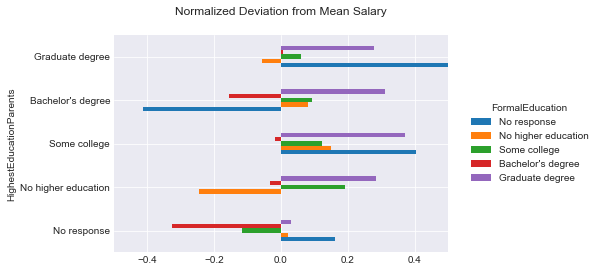

In [36]:
non_oecd_data = df[df['oecd']=='non-oecd']
test = group_plot(non_oecd_data,['FormalEducation','HighestEducationParents'],major_plot_group=1,plot=False)
test.reindex(ordered_ed).plot.barh()
plt.xlim(-0.5,0.5)
plt.ylabel('HighestEducationParents')
lgd = plt.legend(loc='center left',bbox_to_anchor = (1.04,0.5),title='FormalEducation')
plt.title('Normalized Deviation from Mean Salary')
plt.savefig('Non-OECD Normalized Deviation from Mean Salary Grouped HEP and FE.png',
            bbox_extra_artists=(lgd,),bbox_inches='tight',dpi=300)

In the plot above, the group where `HighestEducationParents` was `'Graduate degree'` and `FormalEducation` was `'No response'` had a mean salary that was super high above the `non-oecd` mean salary. I thought it would be worthwhile to check for more information about this group to see if it was anything to be concerned about.

In [21]:
non_oecd_data.groupby(['FormalEducation','HighestEducationParents']).get_group(('No response','Graduate degree'))

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary,oecd
44441,44442,Professional developer,"Yes, both",Costa Rica,I prefer not to say,Employed full-time,No response,NaN,About half the time,I prefer not to answer,...,Male,Graduate degree,Hispanic or Latino/Latina; White or of Europea...,Agree,NaN,Disagree,Strongly agree,95698.924731,NaN,non-oecd


It turns out that there was just one person in it, so I wasn't too worried about just cutting off the plot to get a better view of the rest of the data.

The following code chunk allows us to look at a column where a respondent could pick as many answers as they liked (e.g., `Gender` or `SelfTaughtTypes`) and calculate the mean value of another column (e.g., `Salary`) for any responses containing each of the possible answers. It's probably easisest to just see how it works below, which I'm demonstrating with `SelfTaughtTypes`.

In [22]:
def multi_response(df,x,y):
    '''
    This function takes data with multiple responses from one column in a DataFrame, then calculates a 
    statistic relevant to each possible response for another column in the data frame.
    
    INPUT:
        df - dataframe with a column that has a multi-response categorical column
        column - the name of the column for which you want to find possible responses
    OUTPUT:
        possible_responses - a list of possible responses
    '''
    
    if x not in df.columns:
        return 'Error! Input column is not in DataFrame.'
    if y not in df.columns:
        return 'Error! Response column is not in DataFrame.'
    
    responses = get_possible_responses(df,x)
    
    df1 = df.dropna(subset=[x,y])
    
    test = {}
    
    for answer in responses:
        mean_value = df1[df1[x].str.contains(answer)][y].mean()
        test[answer]=mean_value
    
    test = pd.DataFrame.from_dict(test,orient='index',columns=['Mean'+y])
    
    return test
        

data_test = multi_response(df,'SelfTaughtTypes','Salary')
data_test.sort_values(by='MeanSalary')
        
    

,MeanSalary
Tutoring/mentoring,45914.404274
Company internal community,57079.569951
Stack Overflow Docs,57319.062543
Stack Overflow Q&A,58647.402234
Official documentation,59404.260960
Non-Stack online communities,59790.136732
Textbook,60071.537354
Other,61298.481405
Trade book,61493.066717
Friends network,62906.969030


In [23]:
data_test['MeanSalary'].mean()

58845.653026280386

The following code chunk applies an ordered categorical dtype to the `EducationImportant` column and then does a `group_plot`.

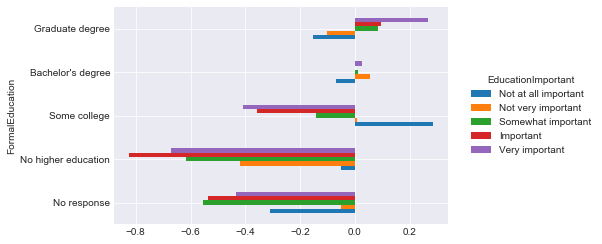

In [24]:
ed_impt_values = ['Not at all important','Not very important','Somewhat important','Important','Very important']
ed_impt_ord_cat = CategoricalDtype(categories=ed_impt_values,ordered=True)

df['EducationImportant']=df['EducationImportant'].astype(ed_impt_ord_cat)

group_plot(df,['EducationImportant','FormalEducation'],major_plot_group=1);

The chunk below defines a function, `single_group_plot`, that's basically the same as `group_plot` except it works on a single group. Also, right now, it only works on things that have the `agree_responses` ordered categorical dtype, because it kept screwing up the order but it's easy enough to set right here.

In [25]:
def single_group_plot(data,group,response_var='Salary',plot=True):
    
    question = schema.loc[group]['Question']
    group_name = ''.join(group)
    group_data = data.groupby(group)[response_var].mean().transform(lambda x: 
                                                                    (x-data[response_var].mean())/data[response_var].std())
    
    group_data = group_data.reindex(agree_responses_ord)
    
    if plot:
        group_data.plot.barh()
        plt.xlabel('Normalized Deviation from Mean Salary')
        plt.title('Responses to: '+question)
        plt.savefig('Normalized deviation from mean salary grouped by '+group_name+'.png',bbox_inches='tight',dpi=300)

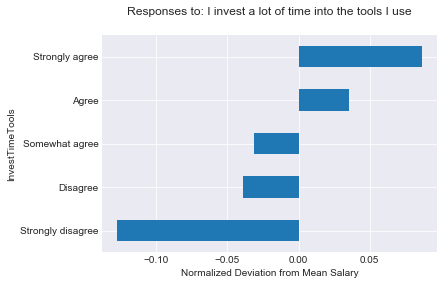

In [26]:
single_group_plot(df,'InvestTimeTools')

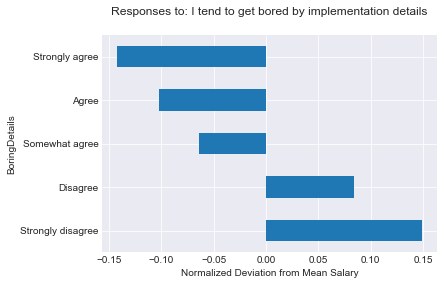

In [27]:
single_group_plot(df,'BoringDetails')

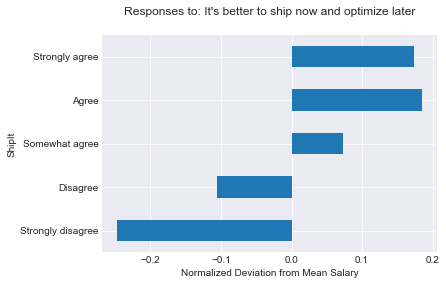

In [28]:
single_group_plot(df,'ShipIt')

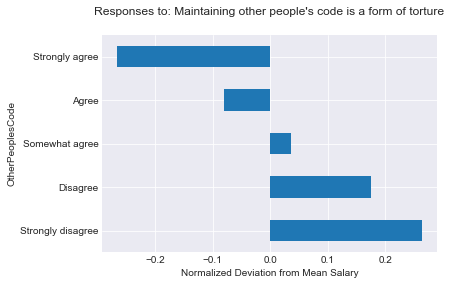

In [29]:
single_group_plot(df,'OtherPeoplesCode')

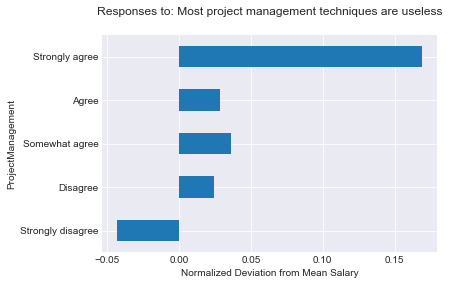

In [30]:
single_group_plot(df,'ProjectManagement')

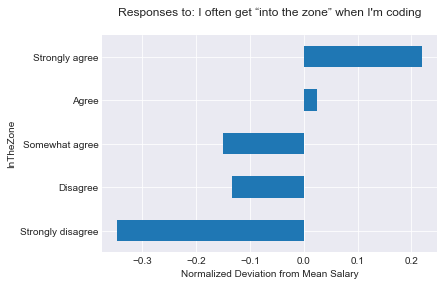

In [31]:
single_group_plot(df,'InTheZone')

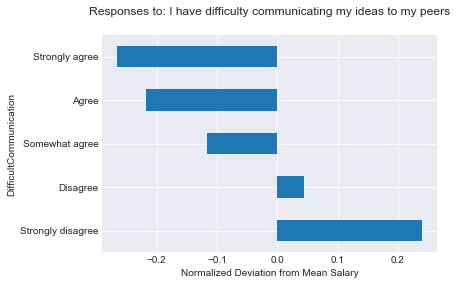

In [32]:
single_group_plot(df,'DifficultCommunication')

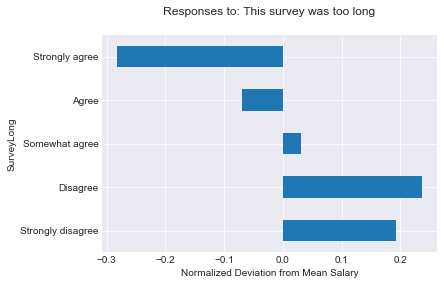

In [33]:
single_group_plot(df,'SurveyLong')